In [33]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from niwtools.tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


In [34]:
from xarrayutils.vertical_remapping import xr_remapping

In [35]:
path = '../data/xarray/qc_7781a.nc'
data = xr.open_dataset(path)
data = data.sel(time=slice('2016-10-04','2016-10-19'))

z = data.z
rho = data.rho0- 1000

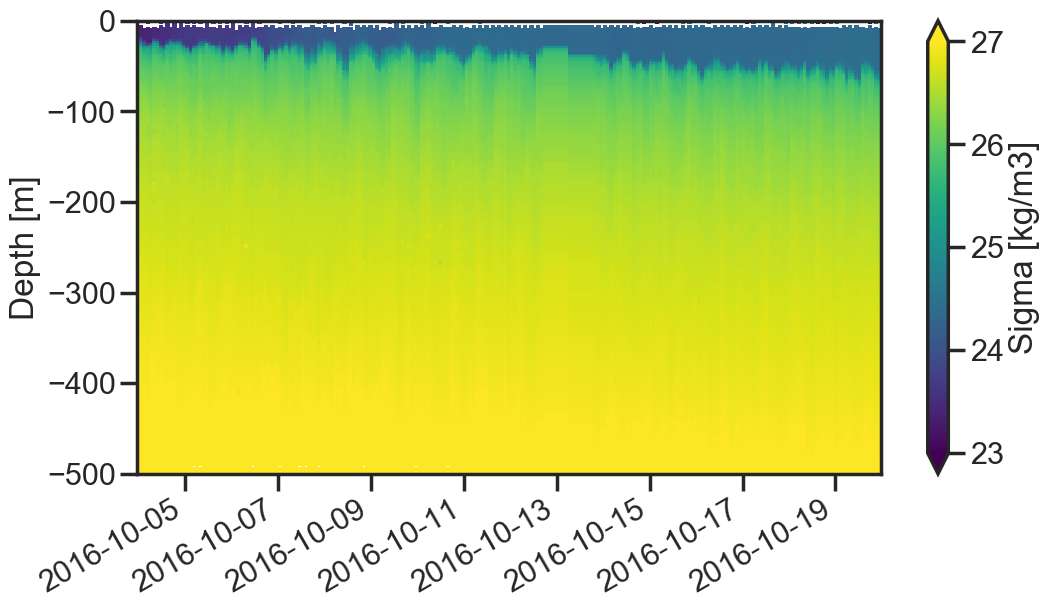

In [36]:
rho.plot(vmin=23,vmax=27,
                 cbar_kwargs={'label':'Sigma [kg/m3]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);
plt.ylim(-500,0);

In [37]:
mrho = rho.median('time')
zpicks = np.linspace(-500,-5,500)
rhobins = np.unique( mrho.interp(z=zpicks).values )

In [38]:
bins=np.linspace(20,30,200)
bins=np.sort( rhobins )

In [39]:
data['zmap'] = data.z
data['sigma'] = data.rho0-1000
data['sigma'],data['zmap'] = xr.broadcast(data.sigma,data.zmap)

In [40]:
remap = xr_remapping(data.zmap,data.sigma,bins, dim='z', distance_coord='z')

(25, 26.8)

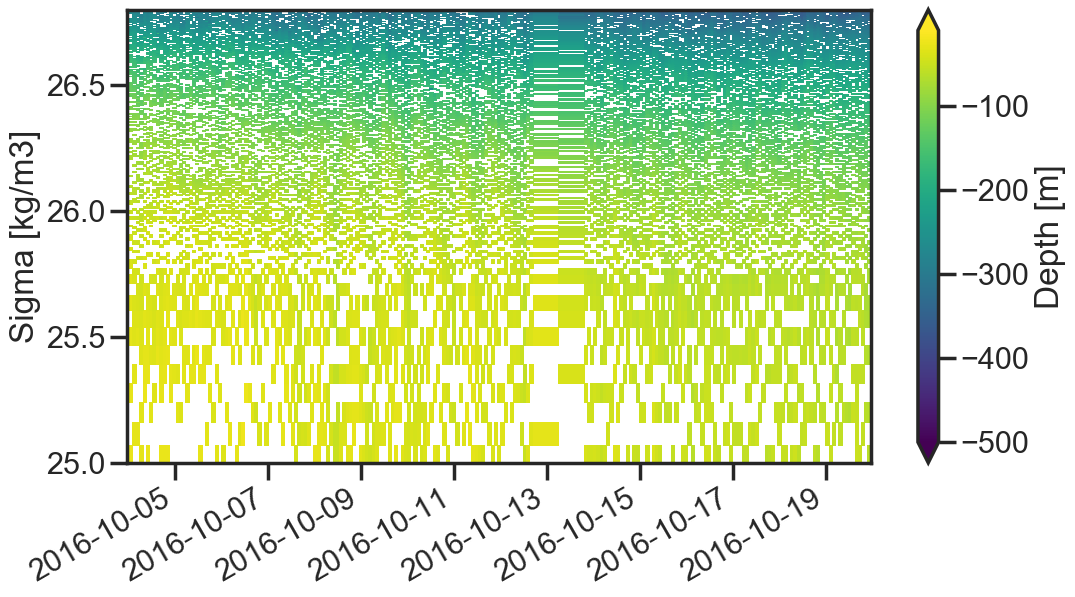

In [41]:
plt.figure(figsize=(12,6))
remap.plot(x='time', vmin=-500,vmax=-10,
                 cbar_kwargs={'label':'Depth [m]'})
plt.ylabel('Sigma [kg/m3]');
plt.xlabel(None);
plt.ylim(25,26.8)

In [42]:
meansigma = data.rolling(time=20).reduce(np.nanmean)
meansigma['zmap'] = meansigma.z
meansigma['sigma'] = meansigma.rho0-1000
meansigma['sigma'],meansigma['zmap'] = xr.broadcast(meansigma.sigma,meansigma.zmap)

In [43]:
remap_mean = xr_remapping(meansigma.zmap,meansigma.sigma,bins, dim='z', distance_coord='z')

In [44]:
ds = xr.Dataset()
ds['displ'] = (remap-remap_mean)
ds['depth'] = remap

(25, 26.8)

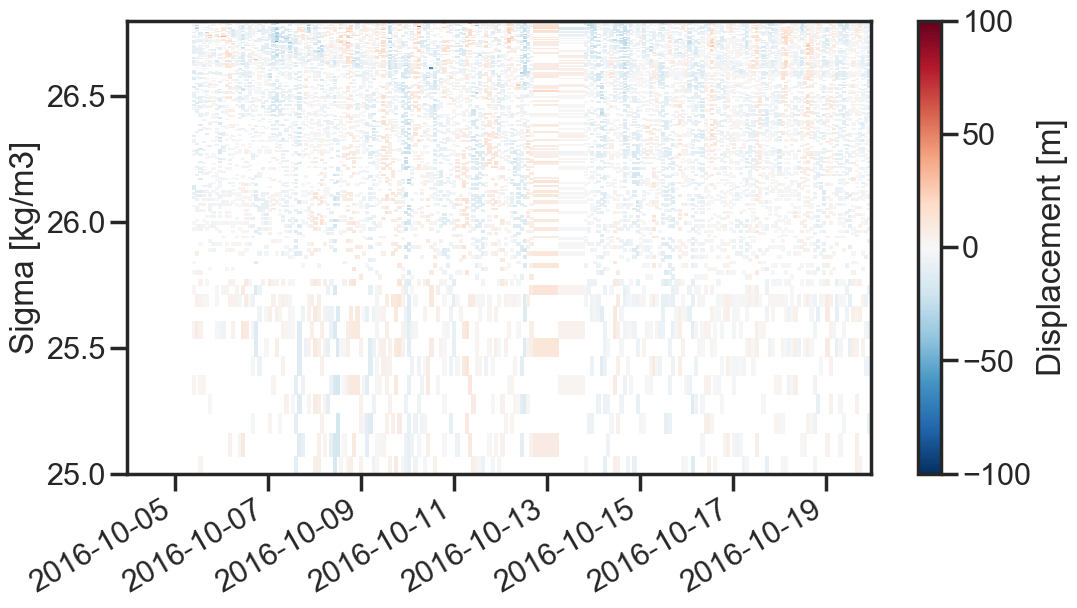

In [45]:
ds.displ.plot(x='time',cmap='RdBu_r',
                 cbar_kwargs={'label':'Displacement [m]'}, vmin=-100,vmax=100)
plt.ylabel('Sigma [kg/m3]');
plt.xlabel(None);
plt.ylim(25,26.8)

In [46]:
# remap = xr_remapping(data.zmap,data.sigma,bins, dim='z', distance_coord='z')
zbins=np.linspace(-500,-5,500)
ds['z'] = ds.depth
ds['sigma'],ds['z'] = xr.broadcast(ds.sigma_layer,ds.z)
remap_depth = xr_remapping(ds.sigma, ds.z, zbins, dim='sigma_layer', distance_coord='sigma_layer')

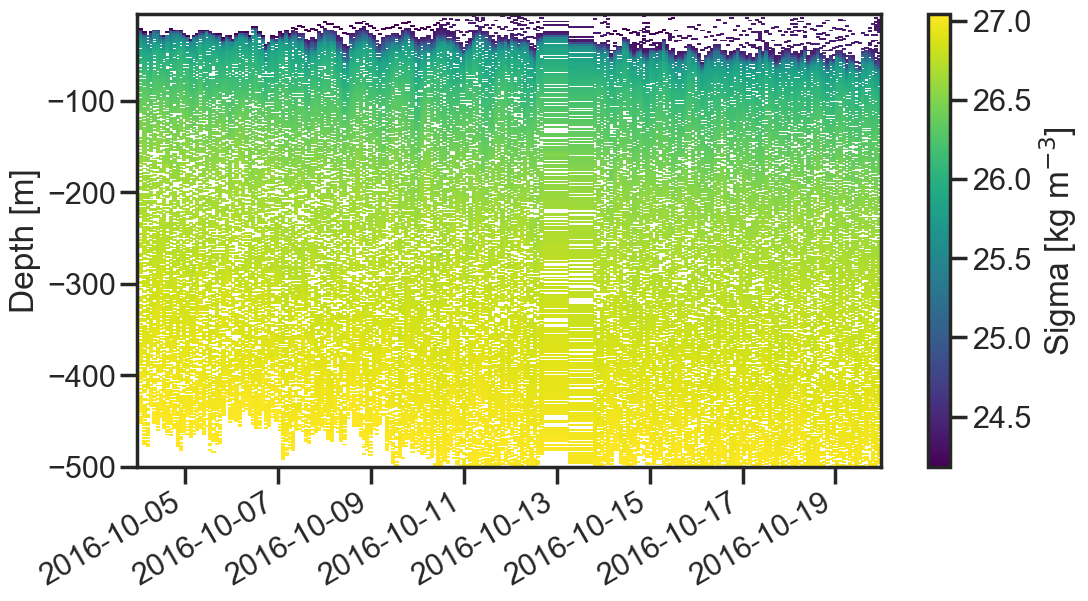

In [47]:
remap_depth.plot(y='z_layer',
                 cbar_kwargs={'label':'Sigma [kg m$^{-3}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [48]:
ds = ds.dropna('time',how='all',subset=['depth'])

In [49]:
newz = np.linspace(-500,-5,500)
deck = []
for t,time in enumerate(ds.time):
    timeslice = ds.isel(time=t)
    timeslice = timeslice.assign_coords(depth=timeslice.depth).swap_dims({'sigma_layer':'depth'})
    timeslice = timeslice.groupby_bins('depth',newz).mean()
    deck.append(timeslice)

In [50]:
zgrid = xr.concat(deck,'time')

In [116]:
zgrid.displ.plot(y='depth_bins',vmin=-40,vmax=40, cmap='RdBu_r',
                 cbar_kwargs={'label':'Displacement [m]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

ValueError: ('zz', 'zz') must be a permuted list of ('time', 'zz'), unless `...` is included

In [52]:
zgrid = zgrid.dropna('time', how='all',subset=['displ'])

In [53]:
def m2km(x):
    return x/1000

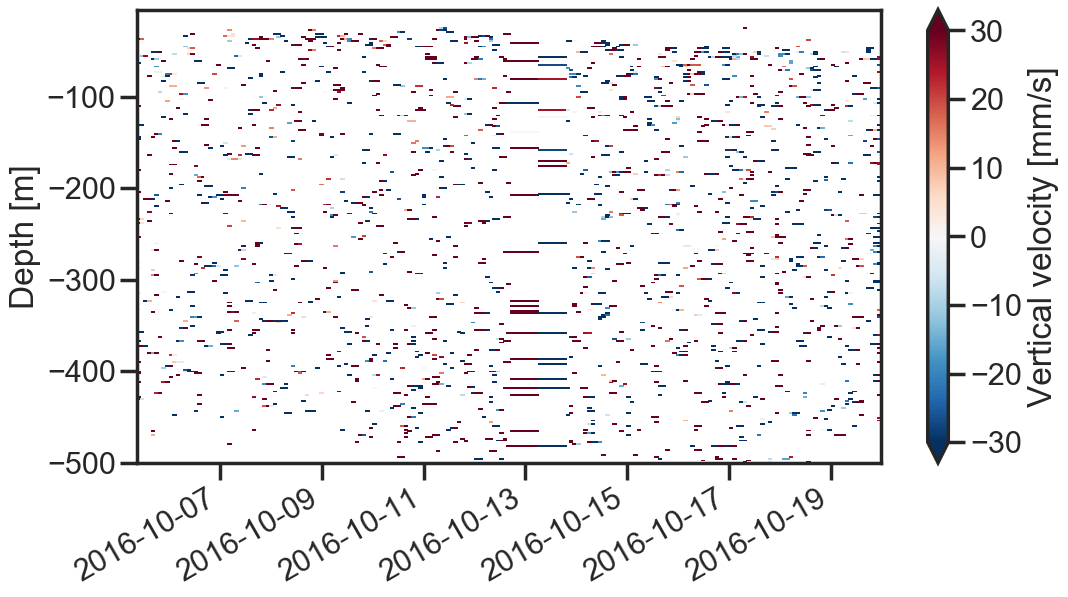

In [54]:
zgrid.differentiate('time',datetime_unit='D').displ.plot(y='depth_bins',vmin=-30,vmax=30, cmap='RdBu_r',
                 cbar_kwargs={'label':'Vertical velocity [mm/s]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [55]:
newz = np.linspace(-500,5,200)
deck = []
for t,time in enumerate(ds.time):
    timeslice = data.isel(time=t)
#     timeslice = timeslice.assign_coords(depth=timeslice.depth).swap_dims({'sigma_layer':'depth'})
    timeslice = timeslice.groupby_bins('z',newz).mean()
    deck.append(timeslice)

In [56]:
data_zgrid = xr.concat(deck,'time')

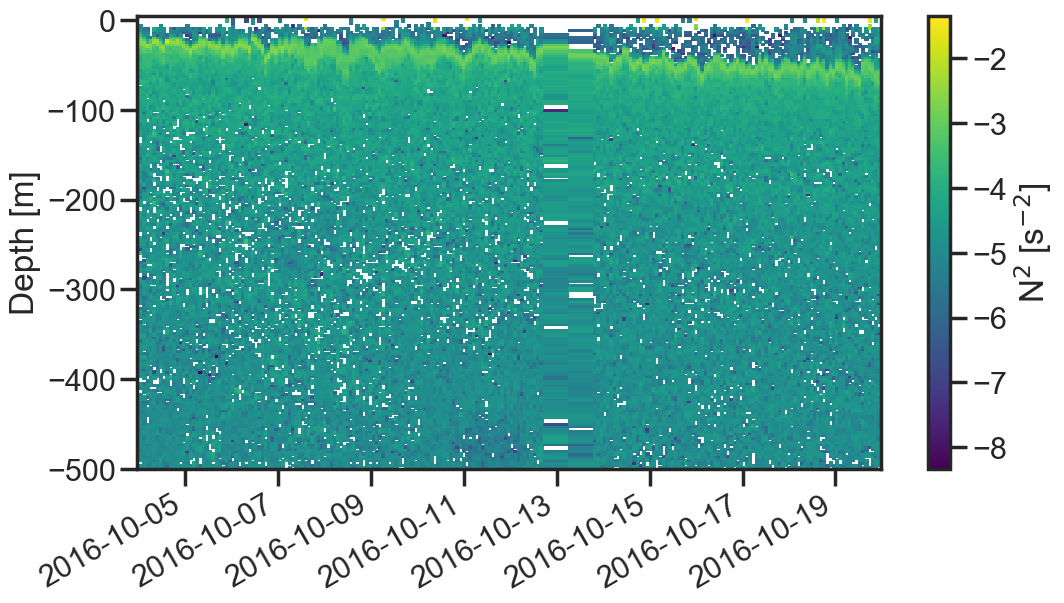

In [57]:
data_zgrid.n2.pipe(np.log10).plot(y='z_bins',
                 cbar_kwargs={'label':r'N$^2$ [s$^{-2}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [58]:
bin_labels = [v.mid for v in zgrid.depth_bins.values]
zgrid['zz'] = ('depth_bins',bin_labels)
zgrid = zgrid.assign_coords(zz=zgrid.zz).swap_dims({'depth_bins':'zz'})

In [59]:
bin_labels = [v.mid for v in data_zgrid.z_bins.values]
data_zgrid['zz'] = ('z_bins',bin_labels)
data_zgrid = data_zgrid.assign_coords(zz=data_zgrid.zz).swap_dims({'z_bins':'zz'})

In [68]:
PE = data_zgrid.n2*zgrid.displ.transpose()**2/2
KE = (data_zgrid.u**2 + data_zgrid.v**2)/2

In [94]:
PE =1025* zgrid.displ.fillna(0).transpose().interp_like(data_zgrid.n2)**2*data_zgrid.n2/2

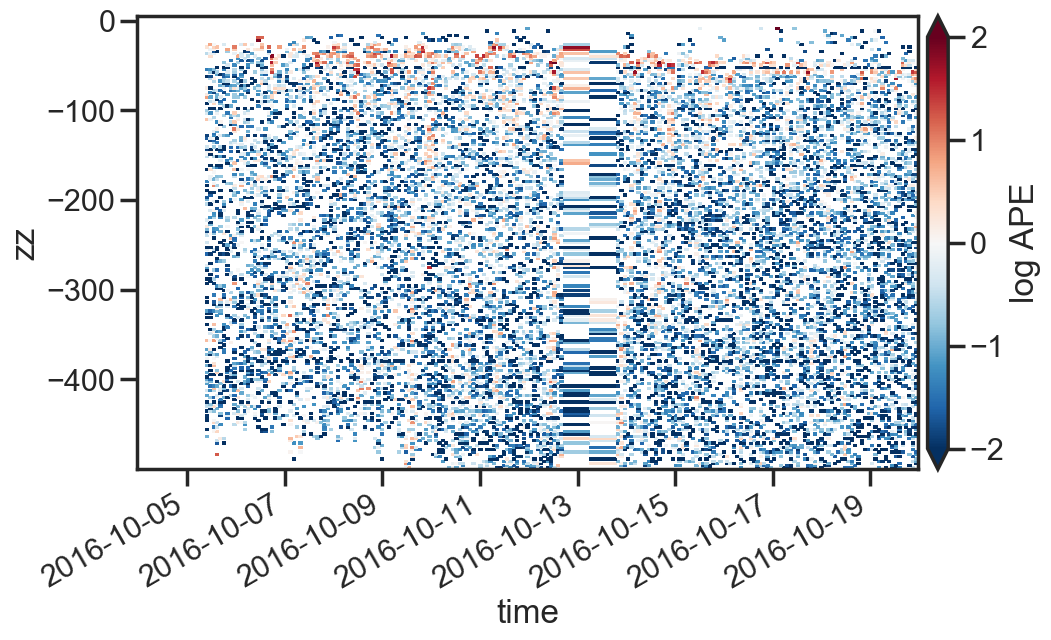

In [115]:
PE.pipe(np.log10).plot(vmin=-2, vmax=2, cmap='RdBu_r', rasterized=True,
                           cbar_kwargs={'pad':0.01,'label':'log APE'})